In [39]:
import pandas as pd
import re
import stanza
import spacy_stanza
import spacy
nlp = spacy_stanza.load_pipeline("ro")

def lemmatize_tokens(tokens):
    doc = nlp(" ".join(tokens))
    lemmatized_tokens = [token.lemma_ for token in doc]
    return lemmatized_tokens

def remove_ner(text):
    doc = nlp(text)
    tokens = []
    for token in doc:
        if token.ent_type_ not in ['MONEY', 'DATE', 'TIME', 'QUANTITY', 'ORDINAL', 'CARDINAL', 'NUMERIC_VALUE', 'PERSON', 'DATETIME']:
            alpha_chars = [char for char in token.text if char.isalpha()]
            cleaned_token = ''.join(alpha_chars)
            if cleaned_token:
                tokens.append(cleaned_token)
    return tokens

def remove_stopwords(tokens):
    stopwords = spacy.lang.ro.stop_words.STOP_WORDS
    filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    return filtered_tokens

def preprocess_text(text):
    tokens = remove_ner(text)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize_tokens(tokens)
    return tokens

def tokenize_text_from_csv(csv_file):
    df = pd.read_csv(csv_file, usecols=['_id', 'category', 'datePublished', 'content', 'title'], nrows=8)  # Read only the first 10 rows
    tokenized_data = []
    
    for index, row in df.iterrows():
        content = row['content']
        tokens = preprocess_text(content)
        tokenized_data.append({
            '_id': row['_id'],
            'category': row['category'],
            'datePublished': row['datePublished'],
            'tokens': tokens
        })
    
    tokenized_df = pd.DataFrame(tokenized_data)
    tokenized_df.to_csv("tokenized_output.csv", index=False, columns=['_id', 'category', 'datePublished', 'tokens'])


csv_file_path = "actualitate.csv"
tokenize_text_from_csv(csv_file_path)


2024-04-14 13:12:59 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-04-14 13:13:00 INFO: Loading these models for language: ro (Romanian):
| Processor | Package      |
----------------------------
| tokenize  | rrt          |
| pos       | rrt_nocharlm |
| lemma     | rrt_nocharlm |
| depparse  | rrt_nocharlm |

2024-04-14 13:13:00 WARNING: GPU requested, but is not available!
2024-04-14 13:13:00 INFO: Using device: cpu
2024-04-14 13:13:00 INFO: Loading: tokenize
2024-04-14 13:13:00 INFO: Loading: pos
2024-04-14 13:13:00 INFO: Loading: lemma
2024-04-14 13:13:00 INFO: Loading: depparse
2024-04-14 13:13:00 INFO: Done loading processors!


In [48]:
import pandas as pd
from gensim import corpora, models
from ast import literal_eval

# Load the CSV file into a DataFrame
df = pd.read_csv('tokenized_output.csv')

# Convert the 'tokens' column from string to list of tokens
df['tokens'] = df['tokens'].apply(literal_eval)

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(df['tokens'])

# Filter out tokens that appear in less than 5 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Create a bag-of-words representation of the documents
corpus = [dictionary.doc2bow(tokens) for tokens in df['tokens']]

# Check if corpus is not empty
if not corpus:
    print("Corpus is empty. Please check your data and filtering criteria.")
else:
    # Train the LDA model
    lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

    # Print the topics and their corresponding words without weights
    for idx, topic in lda_model.print_topics(-1):
        words = topic.split('+')
        topic_words = [word.split('*')[1].replace('"', '').strip() for word in words]
        print(f'Topic: {idx}')
        print(f'Words: {topic_words}')
        print()

    # Save the LDA model
    lda_model.save('lda_model')


Topic: 0
Words: ['respinge', 'loc', 'Newsro', 'sistem', 'urma', 'ac', 'următor', 'reprezentant']

Topic: 1
Words: ['ac', 'Newsro', 'sistem', 'următor', 'urma', 'respinge', 'reprezentant', 'loc']

Topic: 2
Words: ['loc', 'reprezentant', 'sistem', 'următor', 'urma', 'respinge', 'Newsro', 'ac']

Topic: 3
Words: ['respinge', 'reprezentant', 'urma', 'următor', 'ac', 'sistem', 'Newsro', 'loc']

Topic: 4
Words: ['urma', 'sistem', 'ac', 'Newsro', 'următor', 'loc', 'reprezentant', 'respinge']



In [49]:
from gensim import models
from gensim import corpora

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(df['tokens'])

# Create a bag-of-words corpus
corpus = [dictionary.doc2bow(tokens) for tokens in df['tokens']]

# Create a TF-IDF model
tfidf = models.TfidfModel(corpus)

# Apply the model to the corpus to get TF-IDF vectors
tfidf_corpus = tfidf[corpus]

# Train an LDA model on the TF-IDF vectors
lda_model = models.LdaModel(tfidf_corpus, num_topics=5, id2word=dictionary, passes=15)

# Print the topics and their corresponding words without weights
for idx, topic in lda_model.print_topics(-1):
    words = topic.split('+')
    topic_words = [word.split('*')[1].replace('"', '').strip() for word in words]
    print(f'Topic: {idx}')
    print(f'Words: {topic_words}')
    print()


Topic: 0
Words: ['Bucureşti', 'persoană', 'Tate', 'TATE', 'bănuit', 'dosar', 'penal', 'fraţe', 'contestaţie', 'sexual']

Topic: 1
Words: ['guvern', 'majorare', 'leu', 'brut', 'sindicat', 'salariu', 'educație', 'salarial', 'salarizare', 'profesor']

Topic: 2
Words: ['economic', 'operator', 'spune', 'Constantinescu', 'ști', 'minunat', 'încuraja', 'întâmpla', 'vină', 'obișnuit']

Topic: 3
Words: ['Rinkevics', 'medic', 'fost', 'pence', 'Edgars', 'alegere', 'sănătaţe', 'punctaj', 'medicină', 'Mike']

Topic: 4
Words: ['staţie', 'locomotivă', 'tren', 'metrou', 'Brașov', 'abur', 'monta', 'panou', 'element', 'informare']



In [50]:
from gensim import models
from gensim.models import CoherenceModel
from gensim import corpora

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(df['tokens'])

# Create a bag-of-words corpus
corpus = [dictionary.doc2bow(tokens) for tokens in df['tokens']]

# Train an LDA model
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Compute coherence
coherence_model_lda = CoherenceModel(model=lda_model, texts=df['tokens'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f"LDA Model Coherence Score: {coherence_lda}")

# Compute perplexity
perplexity_lda = lda_model.log_perplexity(corpus)
print(f"LDA Model Perplexity: {perplexity_lda}")

# Repeat for another model like TF-IDF + LDA
# Create a TF-IDF model
tfidf = models.TfidfModel(corpus)
tfidf_corpus = tfidf[corpus]

# Train an LDA model on the TF-IDF vectors
lda_model_tfidf = models.LdaModel(tfidf_corpus, num_topics=5, id2word=dictionary, passes=15)

# Compute coherence for TF-IDF + LDA
coherence_model_lda_tfidf = CoherenceModel(model=lda_model_tfidf, texts=df['tokens'], dictionary=dictionary, coherence='c_v')
coherence_lda_tfidf = coherence_model_lda_tfidf.get_coherence()
print(f"TF-IDF + LDA Model Coherence Score: {coherence_lda_tfidf}")

# Compute perplexity for TF-IDF + LDA
perplexity_lda_tfidf = lda_model_tfidf.log_perplexity(tfidf_corpus)
print(f"TF-IDF + LDA Model Perplexity: {perplexity_lda_tfidf}")


LDA Model Coherence Score: 0.5696303892278808
LDA Model Perplexity: -6.705718162309088
TF-IDF + LDA Model Coherence Score: 0.43610769086862194
TF-IDF + LDA Model Perplexity: -9.850723495783805


In [51]:
import pandas as pd
from gensim import corpora, models

# Load the CSV file into a DataFrame
df = pd.read_csv('tokenized_output.csv')

# Convert the 'tokens' column from string to list of tokens
df['tokens'] = df['tokens'].apply(literal_eval)

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(df['tokens'])

# Filter out tokens that appear in less than 5 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Create a bag-of-words representation of the documents
corpus = [dictionary.doc2bow(tokens) for tokens in df['tokens']]

# Train the LDA model
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)


In [52]:
# Get topic vectors for all documents
topic_vectors = [lda_model[doc] for doc in corpus]


In [53]:
from sklearn.decomposition import PCA
import numpy as np

# Convert the topic vectors to a matrix
topic_matrix = np.zeros((len(topic_vectors), lda_model.num_topics))
for i, tv in enumerate(topic_vectors):
    for topic_num, prob in tv:
        topic_matrix[i, topic_num] = prob

# Apply PCA
pca = PCA(n_components=2)  # You can choose the number of components you want
topic_pca = pca.fit_transform(topic_matrix)


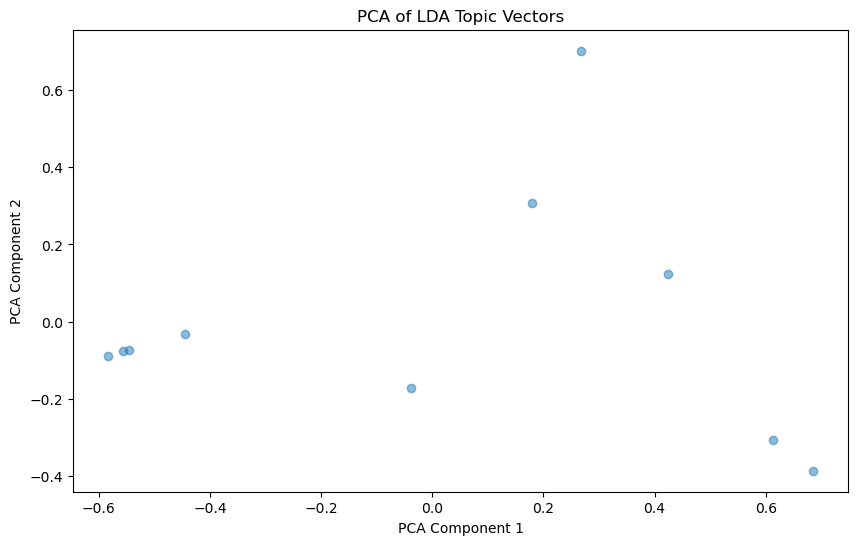

In [54]:
import matplotlib.pyplot as plt

# Plot the PCA results
plt.figure(figsize=(10, 6))
plt.scatter(topic_pca[:, 0], topic_pca[:, 1], alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of LDA Topic Vectors')
plt.show()


Train LDA with word embeddings

In [56]:
from gensim.models import Word2Vec
from gensim.test.utils import common_texts

# Train Word2Vec model on your data
word2vec_model = Word2Vec(df['tokens'], vector_size=100, window=5, min_count=1, sg=0)

# Get embeddings for all words
word_vectors = word2vec_model.wv

# Create a dictionary representation of the documents
word2vec_dict = corpora.Dictionary(df['tokens'])

# Filter out tokens that appear in less than 5 documents or more than 50% of the documents
word2vec_dict.filter_extremes(no_below=5, no_above=0.5)

# Create a bag-of-words representation of the documents
word2vec_corpus = [word2vec_dict.doc2bow(tokens) for tokens in df['tokens']]

# Train the LDA model
lda_word2vec = models.LdaModel(word2vec_corpus, num_topics=5, id2word=word2vec_dict, passes=15)


In [57]:
glove_dict = corpora.Dictionary(df['tokens'])

# Filter out tokens that appear in less than 5 documents or more than 50% of the documents
glove_dict.filter_extremes(no_below=5, no_above=0.5)

glove_corpus = [glove_dict.doc2bow(tokens) for tokens in df['tokens']]

# Train the LDA model
lda_glove = models.LdaModel(glove_corpus, num_topics=5, id2word=glove_dict, passes=15)


In [58]:
fasttext_dict = corpora.Dictionary(df['tokens'])

# Filter out tokens that appear in less than 5 documents or more than 50% of the documents
fasttext_dict.filter_extremes(no_below=5, no_above=0.5)

fasttext_corpus = [fasttext_dict.doc2bow(tokens) for tokens in df['tokens']]

# Train the LDA model
lda_fasttext = models.LdaModel(fasttext_corpus, num_topics=5, id2word=fasttext_dict, passes=15)


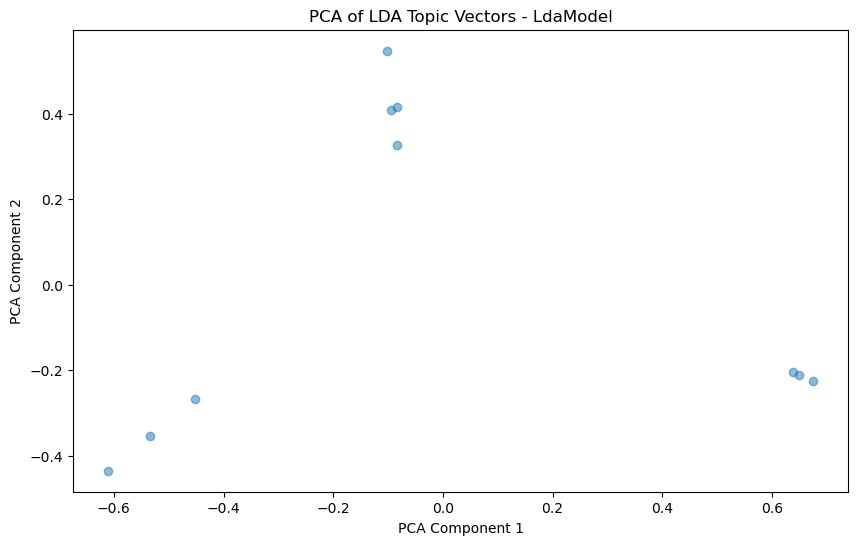

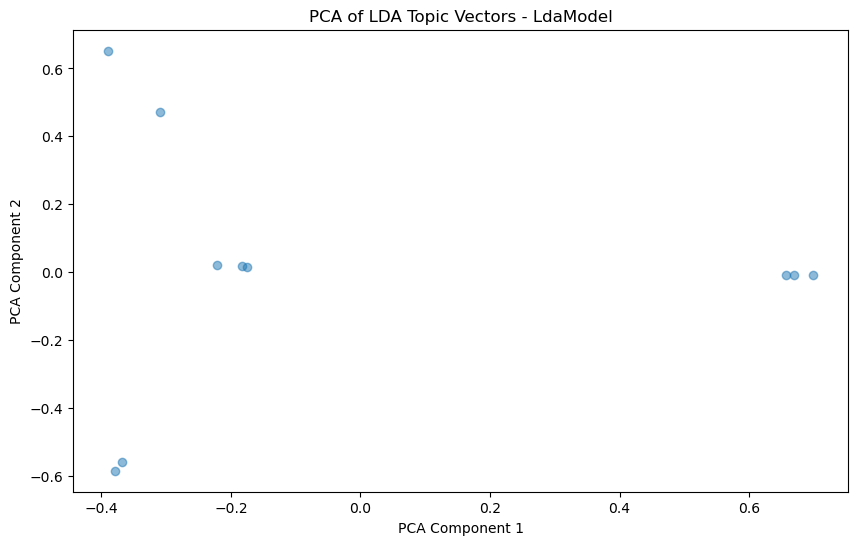

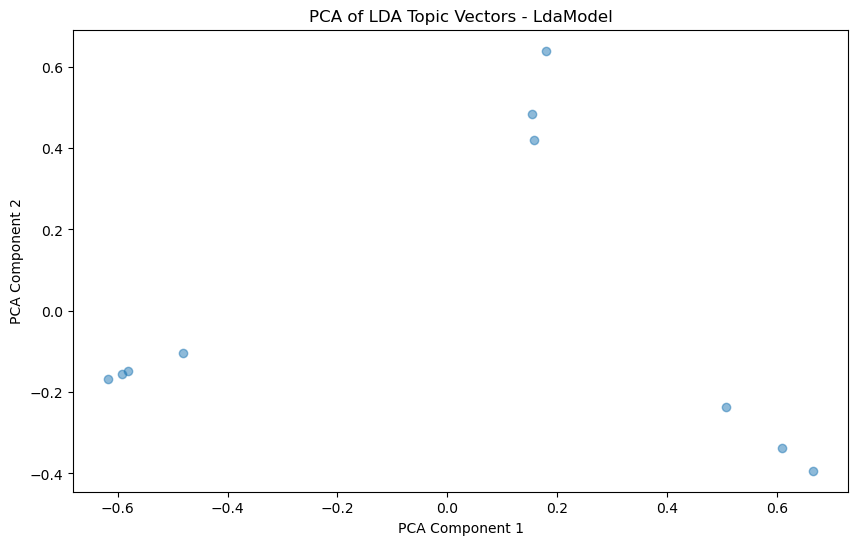

In [59]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

def plot_pca(lda_model, dictionary, corpus):
    # Get topic vectors for all documents
    topic_vectors = [lda_model[doc] for doc in corpus]

    # Convert the topic vectors to a matrix
    topic_matrix = np.zeros((len(topic_vectors), lda_model.num_topics))
    for i, tv in enumerate(topic_vectors):
        for topic_num, prob in tv:
            topic_matrix[i, topic_num] = prob

    # Apply PCA
    pca = PCA(n_components=2)
    topic_pca = pca.fit_transform(topic_matrix)

    # Plot the PCA results
    plt.figure(figsize=(10, 6))
    plt.scatter(topic_pca[:, 0], topic_pca[:, 1], alpha=0.5)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('PCA of LDA Topic Vectors - ' + lda_model.__class__.__name__)
    plt.show()

# Plot for Word2Vec
plot_pca(lda_word2vec, word2vec_dict, word2vec_corpus)

# Plot for GloVe
plot_pca(lda_glove, glove_dict, glove_corpus)

# Plot for FastText
plot_pca(lda_fasttext, fasttext_dict, fasttext_corpus)


In [ ]:
import pandas as pd
from gensim import corpora, models
from ast import literal_eval
from gensim.models import FastText

# Load the CSV file into a DataFrame
df = pd.read_csv('tokenized_output.csv')

# Convert the 'tokens' column from string to list of tokens
df['tokens'] = df['tokens'].apply(literal_eval)

# Train or load your FastText model
# Assuming you have a pre-trained model named fasttext_model
# If you need to train, replace this with your training code
# fasttext_model = FastText(df['tokens'], vector_size=100, window=5, min_count=1, sg=1)

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(df['tokens'])

# Filter out tokens that appear in less than 5 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Create a bag-of-words representation of the documents
corpus = [dictionary.doc2bow(tokens) for tokens in df['tokens']]

# Convert the documents to FastText embeddings
def get_embeddings(document, model):
    return [model[word] for word in document if word in model]

# Convert each document to FastText embeddings
fasttext_corpus = [get_embeddings(tokens, fasttext_model) for tokens in df['tokens']]

# Check if corpus is not empty
if not fasttext_corpus:
    print("Corpus is empty. Please check your data and filtering criteria.")
else:
    # Train the LDA model on FastText embeddings
    lda_model = models.LdaModel(fasttext_corpus, num_topics=5, id2word=dictionary, passes=15)

    # Print the topics and their corresponding words without weights
    for idx, topic in lda_model.print_topics(-1):
        words = topic.split('+')
        topic_words = [word.split('*')[1].replace('"', '').strip() for word in words]
        print(f'Topic: {idx}')
        print(f'Words: {topic_words}')
        print()

    # Save the LDA model
    lda_model.save('lda_model')
